In [24]:
import torch
use_gpu = True if torch.cuda.is_available() else False
device = "cuda:0"  if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
np.random.seed(0)
torch.backends.cudnn.benchmark = True
import torch.nn.functional as F
from tqdm.auto import tqdm
import os

In [26]:
save_dir = "BaryCenter"

In [22]:
class Generator(torch.nn.Module):
    def __init__(self, latent_dim, num_filters):
        super(Generator, self).__init__()

        # Hidden layers
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Deconvolutional layer
            if i == 0:
                deconv = torch.nn.ConvTranspose2d(latent_dim, num_filters[i], kernel_size=4, stride=1, padding=0)
            else:
                deconv = torch.nn.ConvTranspose2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

            deconv_name = 'deconv' + str(i + 1)
            self.hidden_layer.add_module(deconv_name, deconv)

            torch.nn.init.normal_(deconv.weight, mean=0.0, std=0.02)
            torch.nn.init.constant_(deconv.bias, 0.0)

            # Batch normalization
            bn_name = 'bn' + str(i + 1)
            self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

            # Activation
            act_name = 'act' + str(i + 1)
            self.hidden_layer.add_module(act_name, torch.nn.ReLU())

        # Output layer
        self.output_layer = torch.nn.Sequential()
        
        # Deconvolutional layer
        out = torch.nn.ConvTranspose2d(num_filters[i], 3, kernel_size=4, stride=2, padding=1)
        self.output_layer.add_module('out', out)
        torch.nn.init.normal_(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(out.bias, 0.0)
        
        # Activation
        self.output_layer.add_module('act', torch.nn.Tanh())

    def forward(self, x):
        x = self.hidden_layer(x)
        out = self.output_layer(x)
        return out

# Discriminator model
class Discriminator(torch.nn.Module):
    def __init__(self, num_filters):
        super(Discriminator, self).__init__()

        # Hidden layers
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Convolutional layer
            if i == 0:
                conv = torch.nn.Conv2d(3, num_filters[i], kernel_size=4, stride=2, padding=1)
            else:
                conv = torch.nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

            conv_name = 'conv' + str(i + 1)
            self.hidden_layer.add_module(conv_name, conv)

            # Initializer
            torch.nn.init.normal_(conv.weight, mean=0.0, std=0.02)
            torch.nn.init.constant_(conv.bias, 0.0)

            # Batch normalization
            if i > 0:
                bn_name = 'bn' + str(i + 1)
                self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

            # Activation
            act_name = 'act' + str(i + 1)
            self.hidden_layer.add_module(act_name, torch.nn.LeakyReLU(0.2))

        # Output layer
        self.output_layer = torch.nn.Sequential()
        # Convolutional layer
        out = torch.nn.Conv2d(num_filters[i], 1, kernel_size=4, stride=1, padding=0)
        self.output_layer.add_module('out', out)
        # Initializer
        torch.nn.init.normal_(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', torch.nn.Sigmoid())

    def forward(self, x):
        x = self.hidden_layer(x)
        out = self.output_layer(x)
        return out

# Encoder model
class Encoder(torch.nn.Module):
    def __init__(self, num_filters, latent_dim):
        super(Encoder, self).__init__()

        # Hidden layers
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Convolutional layer
            if i == 0:
                conv = torch.nn.Conv2d(3, num_filters[i], kernel_size=4, stride=2, padding=1)
            else:
                conv = torch.nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

            conv_name = 'conv' + str(i + 1)
            self.hidden_layer.add_module(conv_name, conv)

            # Initializer
            torch.nn.init.normal_(conv.weight, mean=0.0, std=0.02)
            torch.nn.init.constant_(conv.bias, 0.0)

            # Batch normalization
            if i > 0:
                bn_name = 'bn' + str(i + 1)
                self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

            # Activation
            act_name = 'act' + str(i + 1)
            self.hidden_layer.add_module(act_name, torch.nn.LeakyReLU(0.2))

        # Output layer
        self.output_layer = torch.nn.Sequential()
        # Convolutional layer
        out = torch.nn.Conv2d(num_filters[i], latent_dim, kernel_size=4, stride=1, padding=0)
        self.output_layer.add_module('out', out)
        # Initializer
        torch.nn.init.normal_(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('bn_out', torch.nn.BatchNorm2d(latent_dim))

    def forward(self, x):
        x = F.interpolate(x, size=(64, 64))
        x = self.hidden_layer(x)
        out = self.output_layer(x)
        return out

In [35]:
# Generator bad use PGAN

#this model outputs 256 x 256 pixel images
use_gpu = True if torch.cuda.is_available() else False
G = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-256',
                       pretrained=True, useGPU=False).netG
G = G.to(device)
latent_dim = 512

E = Encoder(num_filters=[128, 256, 512, 1024], latent_dim=latent_dim).to(device)
E.load_state_dict(torch.load(os.path.join(save_dir,'encoder')))
E = E.to(device)
G.eval()
E.eval()

Using cache found in /home/extra/marvin852316497/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


Encoder(
  (hidden_layer): Sequential(
    (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (act1): LeakyReLU(negative_slope=0.2)
    (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): LeakyReLU(negative_slope=0.2)
    (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): LeakyReLU(negative_slope=0.2)
    (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act4): LeakyReLU(negative_slope=0.2)
  )
  (output_layer): Sequential(
    (out): Conv2d(1024, 512, kernel_size=(4, 4), stride=(1, 1))
    (bn_out): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [6]:
%matplotlib inline
def show(img, fig_size=(12,8)):
    npimg = img.numpy()
    fig = plt.figure(figsize=fig_size, dpi=100) 
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')    

In [2]:
from typing import List, Tuple
from numba import jit
# Compute the L2 metric for the transportation cost. Can probably be vectorized to run faster.
@jit("float64[:,:](int64,int64,int64[:,:,:])",nopython=True)
def _generate_metric(height, width, grid):
    # Could probably inpmprove runtime using vectorized code
    C = np.zeros((height*width, height*width))
    i = 0
    j = 0
    for y1 in range(width):
        for x1 in range(height):
            for y2 in range(width):
                for x2 in range(height):
                    C[i,j] = np.square(grid[x1,y1,:] - grid[x2,y2,:]).sum()
                    j += 1
            j = 0
            i += 1
    return C

def generate_metric(im_size: Tuple[int]) -> np.ndarray:
    """
    Computes the Euclidean distances matrix
    
    Arguments:
        im_size {Tuple[int]} -- Size of the input image (height, width)
    
    Returns:
        np.ndarray -- distances matrix
    """
    grid = np.meshgrid(*[range(x) for x in im_size])
    grid = np.stack(grid,-1)
    return _generate_metric(im_size[0], im_size[1], grid)

In [3]:
# Find interpolation given the transportation plan. Can probably be vectorized to run faster.
@jit("float64[:,:](int64,int64,float64[:,:,:,:],float32)",nopython=True)
def generate_interpolation(height, width, plan, t):
    c = np.zeros((height+1, width+1))
    for y1 in range(width):
        for x1 in range(height):
            for y2 in range(width):
                for x2 in range(height):
                    new_loc_x = (1-t)*x1 + t*x2
                    new_loc_y = (1-t)*y1 + t*y2
                    p = new_loc_x - int(new_loc_x)
                    q = new_loc_y - int(new_loc_y)
                    c[int(new_loc_x),int(new_loc_y)] += (1-p)*(1-q)*plan[x1,y1,x2,y2]
                    c[int(new_loc_x)+1,int(new_loc_y)] += p*(1-q)*plan[x1,y1,x2,y2]
                    c[int(new_loc_x),int(new_loc_y)+1] += (1-p)*q*plan[x1,y1,x2,y2]
                    c[int(new_loc_x)+1,int(new_loc_y)+1] += p*q*plan[x1,y1,x2,y2]
    c = c[:height,:width] #* (I1_count*(1-t) + I2_count*t)
    return c

def sinkhorn(a: np.ndarray, b: np.ndarray, C: np.ndarray, height: int, width: int, 
             epsilon: float, threshold: float=1e-7) -> np.ndarray:
    """Computes the sinkhorn algorithm naively, using the CPU.
    
    Arguments:
        a {np.ndarray} -- the first distribution (image), normalized, and shaped to a vector of size height*width.
        b {np.ndarray} -- the second distribution (image), normalized, and shaped to a vector of size height*width.
        C {np.ndarray} -- the distances matrix
        height {int} -- image height
        width {int} -- image width
        epsilon {float} -- entropic regularization parameter
    
    Keyword Arguments:
        threshold {float} -- convergence threshold  (default: {1e-7})
    
    Returns:
        np.ndarray -- the entropic regularized transportation plan, pushing distribution a to b.
    """
    K = np.exp(-C/epsilon)
    v = np.random.randn(*a.shape)
    i = 0
    while True:
        u = a/(K.dot(v))
        v = b/(K.T.dot(u))
        i += 1
        if i % 50 == 0:
            convergence = np.square(np.sum(u.reshape(-1, 1) * K * v.reshape(1,-1), axis=1) - a).sum()
            if convergence < threshold:
                print(f"Iteration {i}. Sinkhorn convergence: {convergence:.2E} (Converged!)")
                break
            else:
                print(f"Iteration {i}. Sinkhorn convergence: {convergence:.2E} ( > {threshold})")

    P = u.reshape(-1, 1) * K * v.reshape(1,-1)
    P = P.reshape(height, width, height, width)
    return P

def preprocess_Q(Q: np.ndarray, max_val: float=None, Q_counts: np.ndarray=None) -> Tuple[np.ndarray, float, np.ndarray]:
    """ Preprocess (normalize) input images before computing their barycenters
    
    Arguments:
        Q {np.ndarray} -- Input images. Every image should reshaped to a column in Q.
    
    Keyword Arguments:
        max_val {float} -- The maximum value. Should be changed from None when using the iterative algorithm (more than 1 iteration in the Algorithm) (default: {None})
        Q_counts {np.ndarray} -- The sum of all the pixel values in each image. Should be changed from None when using the iterative algorithm (more than 1 iteration in the Algorithm) (default: {None})
    
    Returns:
        Tuple[np.ndarray, float, np.ndarray] -- The normalized images the total maximum value and sum of pixels in each image
    """
    if max_val is None:
        max_val = Q.max()
    Q = max_val - Q
    if Q_counts is None:
        Q_counts = np.sum(Q, axis=1, keepdims=True)
    Q = Q / Q_counts
    return Q, max_val, Q_counts

In [4]:
import glob
from torchvision import transforms
from PIL import Image
female = []
male = []
#normalize to -1 ~ 1
trans = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
for img in glob.glob("celeba_hq/val/female/*.jpg")[:32]:
    female.append(trans(Image.open(img)))
for img in glob.glob("celeba_hq/val/male/*.jpg")[:32]:
    male.append(trans(Image.open(img)))

32


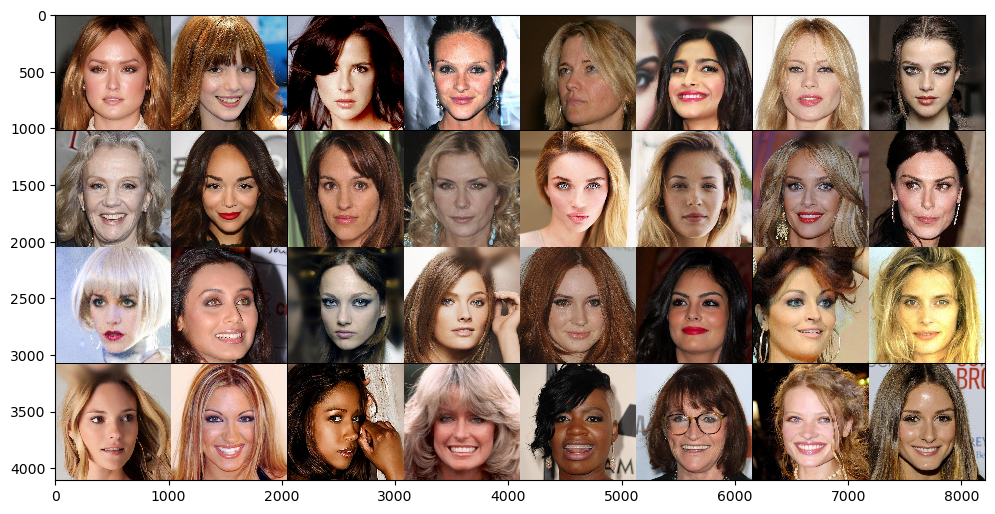

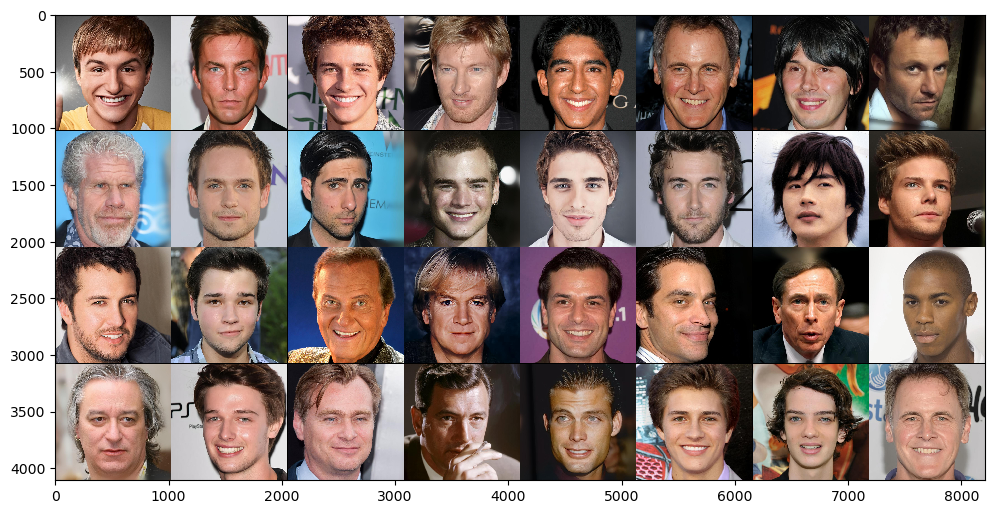

In [11]:
print(len(female))
show(make_grid(torch.stack(female), normalize=True, range=(-1.,1.)))
show(make_grid(torch.stack(male), normalize=True, range=(-1.,1.)))

In [12]:
src_img_idx = 1
target_img_idx = 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 64, 64]) torch.Size([1, 3, 64, 64])


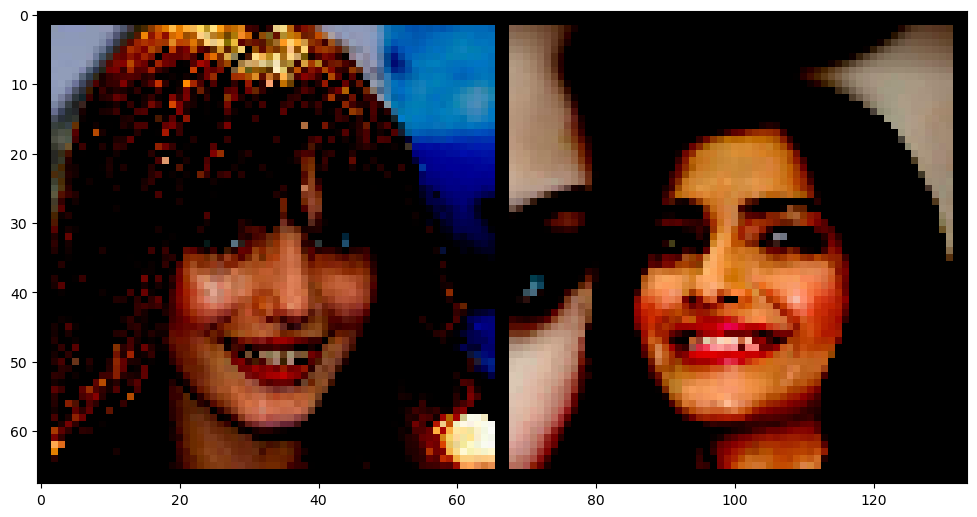

In [15]:
im1 = F.interpolate(female[src_img_idx].unsqueeze(0), size=(64,64))
im2 = F.interpolate(female[target_img_idx].unsqueeze(0), size=(64,64))
print(im1.shape, im2.shape)
show(make_grid(torch.cat([im1, im2], 0)))
im1, im2 = (I.reshape(3,-1,1) for I in (im1.numpy(), im2.numpy()))



In [19]:
img_size = (64, 64)
epsilon = 20.0
L = 9
print("Preparing transportation cost matrix...")
C = generate_metric(img_size)
Q = np.concatenate([im1, im2], axis=-1)
Q, max_val, Q_counts = preprocess_Q(Q)
out_ours = []
out_GAN = []
out_OT = []

print("Computing transportation plan...")
for dim in range(3):
    print(f"Color space {dim+1}/3")
    out_OT.append([])
    P = sinkhorn(Q[dim,:,0], Q[dim,:,1], C, img_size[0], img_size[1], epsilon)
    for t in tqdm(np.linspace(0,1,L)):
        out_OT[-1].append(max_val - generate_interpolation(img_size[0],img_size[1],P,t)*((1-t)*Q_counts[dim,0,0] + t*Q_counts[dim,0,1]))
out_OT = [np.stack(im_channels, axis=0) for im_channels in zip(*out_OT)]

Preparing transportation cost matrix...
Computing transportation plan...
Color space 1/3
Iteration 50. Sinkhorn convergence: 5.35E-02 ( > 1e-07)
Iteration 100. Sinkhorn convergence: 2.09E-07 ( > 1e-07)
Iteration 150. Sinkhorn convergence: 1.94E-08 (Converged!)


  0%|          | 0/9 [00:00<?, ?it/s]

Color space 2/3
Iteration 50. Sinkhorn convergence: 1.15E-06 ( > 1e-07)
Iteration 100. Sinkhorn convergence: 1.13E-07 ( > 1e-07)
Iteration 150. Sinkhorn convergence: 1.19E-08 (Converged!)


  0%|          | 0/9 [00:00<?, ?it/s]

Color space 3/3
Iteration 50. Sinkhorn convergence: 1.30E-01 ( > 1e-07)
Iteration 100. Sinkhorn convergence: 3.14E-01 ( > 1e-07)
Iteration 150. Sinkhorn convergence: 1.43E+00 ( > 1e-07)
Iteration 200. Sinkhorn convergence: 8.12E-02 ( > 1e-07)
Iteration 250. Sinkhorn convergence: 7.03E-09 (Converged!)


  0%|          | 0/9 [00:00<?, ?it/s]

In [33]:
import torch.nn as nn
def project_on_generator(G: nn.Module, target_image: np.ndarray, iters=500, eta: float=1e-9, eps: float=1e-4, z_dim: int=512
                         ) -> Tuple[np.ndarray, torch.Tensor]:
    
    # target_image (3, 64, 64)
    # image (3, 256, 256)
    image = F.interpolate(torch.tensor(target_image, device = device).unsqueeze(0), (256, 256)).float()    
    z = E(image)
    PGAN_image = G(z)
    return PGAN_image.cpu().detach().squeeze(0), z


In [36]:
print("Computing GAN projections...")
iters = 5
# Project OT results on GAN
GAN_projections = []
for I in out_OT:
    I_, z = project_on_generator(G, I)
    GAN_projections.append((I_, z))

GAN_projections_images, GAN_projections_noises = zip(*GAN_projections)
out_ours = GAN_projections_images

Computing GAN projections...
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


In [38]:
# Linearly interpolate GAN's latent space
noise1 = GAN_projections_noises[0]
noise2 = GAN_projections_noises[-1]
out_GAN = []
GAN_interp_noises = []
for t in np.linspace(0,1,L):
    t = float(t)  # cast numpy object to primative type
    z_inter = (1-t)*noise1 + t*noise2
    GAN_interp_noises.append(z_inter)
    GAN_image = G(z_inter).cpu().data
    GAN_image = F.interpolate(GAN_image, img_size).squeeze(0)

    GAN_image = GAN_image.numpy()
    out_GAN.append(GAN_image)

In [39]:
img_size = (64,64)
out_ours = [F.interpolate(i.unsqueeze(0), img_size).squeeze(0) for i in out_ours]

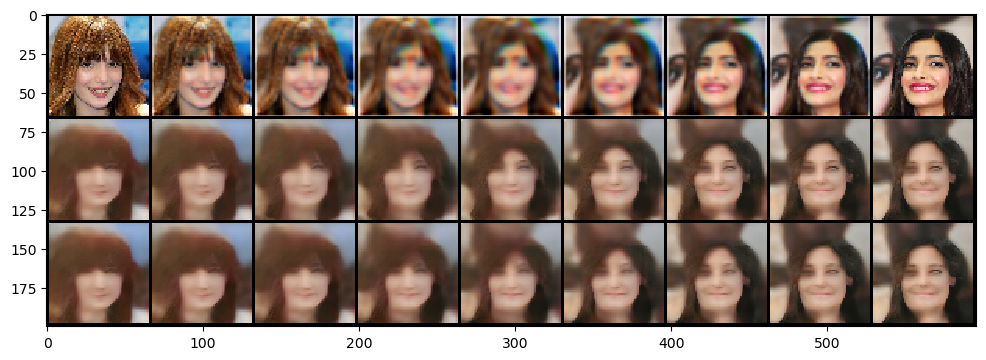

In [40]:
final_OT = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_OT])
final_ours = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_ours])
final_GAN = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_GAN])
show(make_grid(torch.cat([final_OT,final_ours, final_GAN], dim=0), 
        normalize=True,
        nrow=L,
        range=(-1,1)))